In [19]:
# Tensorflow imports
from keras.models import Sequential, load_model, model_from_json, Model
from keras.layers import Dense, Dropout, Input, BatchNormalization, LSTM, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ModelCheckpoint
from keras import backend as K
from keras import optimizers, regularizers
import keras

# Sklearn imports
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Mongo
from pymongo import MongoClient

# Pandas and numpy
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(18, 4)})

# Other
from scipy.ndimage.filters import gaussian_filter1d
from IPython.display import Image
from datetime import datetime, timedelta
from math import sqrt

import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" 

In [4]:
sns.set(rc={'figure.figsize':(18, 4)})

### Connect to mongo database

In [5]:
# Mongo client
client = MongoClient('mongodb://165.22.199.122:27017')
db = client.processed
data = db.internal

In [6]:
# Load the data
df= (pd.DataFrame(list(data.find()))
    .drop(['_id', 'window'], 1)
    .set_index('timestamp')
    .sort_index()
    .dropna())

df['price_diff'] = df['price'].diff(1)
df = df.dropna()
df = df[df['price_diff'].abs() < 40]
df = df[df['n_tweets'] >= 190]
df = df.iloc[3:-3]

print(df.shape)
df.head()

(5286, 4)


,sentiment,n_tweets,price,price_diff
timestamp,,,,
2019-11-03 14:58:00,0.173610,316,9192.100,2.921
2019-11-03 15:00:00,0.163184,313,9195.474,3.374
2019-11-03 15:02:00,0.151912,385,9193.544,-1.930
2019-11-03 15:04:00,0.135992,429,9190.258,-3.286
2019-11-03 15:06:00,0.145232,473,9186.290,-3.968


### Function to create timeline plot

In [7]:
def plot_timeline(first_feature, second_feature):
    sns.set_style("dark")
    
    fig, ax1 = plt.subplots()

    ax1.plot(df['2019-01-02 08:00:00':][first_feature], label=first_feature)
    ax1.legend(loc='upper left')
    ax2 = ax1.twinx()
    ax2.plot(df['2019-01-02 08:00:00':][second_feature], color='orange', label=second_feature)
    ax2.legend(loc='upper right')

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


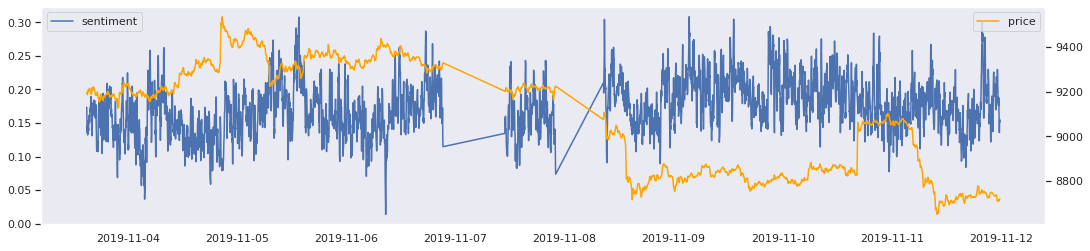

In [8]:
plot_timeline('sentiment', 'price')

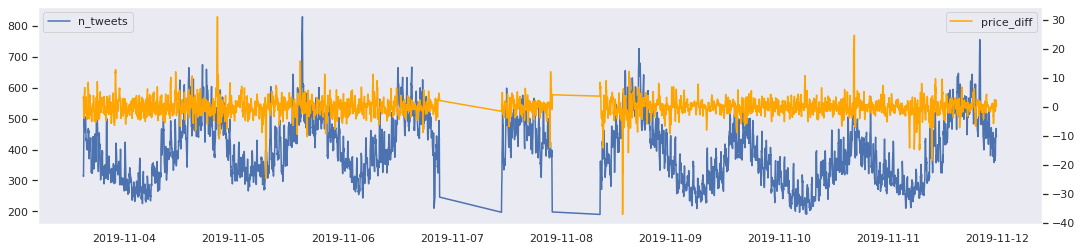

In [9]:
plot_timeline('n_tweets', 'price_diff')

### Prepare training data

In [12]:
np.set_printoptions(suppress=True)

In [13]:
def split_sequence(sequence, n_steps):
    X = []
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x = sequence[i:end_ix]
        X.append(seq_x)
        
    return np.array(X)

def generate_train_test(n_steps=12, train_size=.75, flatten=True):
    train_size = int(train_size * len(df))
    
    prices = df['price'].values
    prices_train, prices_test = prices[:train_size], prices[train_size:]
    
    price_diff = df['price_diff'].values
    price_diff_train, price_diff_test = price_diff[:train_size], price_diff[train_size:]
    
    sentiment = df['sentiment'].values
    sentiment_train, sentiment_test = sentiment[:train_size], sentiment[train_size:]
    
    n_tweets = df['n_tweets'].values
    n_tweets_train, n_tweets_test = n_tweets[:train_size], n_tweets[train_size:]
    
    train = np.stack([prices_train, sentiment_train, n_tweets_train], axis=1)
    test = np.stack([prices_test, sentiment_test, n_tweets_test], axis=1)
    
    # Scale the data
    scaler = StandardScaler()
#     train_scaled = scaler.fit_transform(train)
#     test_scaled = scaler.transform(test)
    train_scaled = train
    test_scaled = test
    
    # Create the sequence
    X_train = split_sequence(train_scaled, n_steps)
    X_test = split_sequence(test_scaled, n_steps)
    
    y_prices = df['price']

    y_train = y_prices.iloc[n_steps:len(X_train)+n_steps].values
    y_test = y_prices.iloc[-len(X_test):].values
    
    # Flatten the timeseries
    if flatten:
        X_train = X_train.reshape(-1, X_train.shape[1]*X_train.shape[2], order='F')
        X_test = X_test.reshape(-1, X_test.shape[1]*X_test.shape[2], order='F')
        
    return X_train, X_test, y_train, y_test

In [14]:
X_train, X_test, y_train, y_test = generate_train_test(n_steps=3, flatten=True)
X_train.shape

(3961, 9)

In [15]:
X_train[0]

array([9192.1       , 9195.474     , 9193.544     ,    0.17361044,
          0.16318371,    0.15191169,  316.        ,  313.        ,
        385.        ])

In [16]:
y_train[0]

9190.258

### Build the keras model

In [17]:
# model.add(BatchNormalization())
# model.add(Dropout(.65))
# model.add(Dense(41, activation='relu'))
# model.add(LSTM(32, activation='relu'))
# model.add(LSTM(64, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))

In [18]:
keras.__version__

NameError: name 'keras' is not defined

In [33]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

def build_lstm_model():
    model = Sequential()
    
    model.add(LSTM(32, activation='relu', input_shape=(3, 4)))
    model.add(Dense(16, activation='relu'))
    
    model.add(Dense(1))
    model.compile(optimizer='rmsprop', loss=root_mean_squared_error)
    
    return model

def build_model():
    model = Sequential()
    model.add(Dense(16, activation='relu', input_shape=(X_train.shape[1],), 
#                     kernel_regularizer=regularizers.l2(0.01)
                   ))
    
    model.add(Dense(8, activation='relu', 
#                     kernel_regularizer=regularizers.l2(0.01)
                   ))
        
    model.add(Dense(1))
#     model.compile(optimizer='adam', loss=root_mean_squared_error)
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

In [34]:
# Create the model
model = build_model()

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Checkpoints
checkpointer = ModelCheckpoint(filepath='models/keras_weights.hdf5',
                                   verbose=1,
                                   save_best_only=True)

# Fit the model
model.fit(
    X_train, 
    y_train, 
    validation_split=0.33,
    epochs=256, 
    batch_size=64,
    callbacks=[checkpointer, early_stopping]);

Train on 2653 samples, validate on 1308 samples
Epoch 1/256
2653/2653 [==============================] - 0s 114us/step - loss: 35945014.9815 - val_loss: 15397078.1070

Epoch 00001: val_loss improved from inf to 15397078.10703, saving model to models/keras_weights.hdf5
Epoch 2/256
2653/2653 [==============================] - 0s 20us/step - loss: 7899449.7158 - val_loss: 1675017.2305

Epoch 00002: val_loss improved from 15397078.10703 to 1675017.23050, saving model to models/keras_weights.hdf5
Epoch 3/256
2653/2653 [==============================] - 0s 20us/step - loss: 524266.1395 - val_loss: 25483.7612

Epoch 00003: val_loss improved from 1675017.23050 to 25483.76124, saving model to models/keras_weights.hdf5
Epoch 4/256
2653/2653 [==============================] - 0s 20us/step - loss: 6952.0787 - val_loss: 4736.8438

Epoch 00004: val_loss improved from 25483.76124 to 4736.84380, saving model to models/keras_weights.hdf5
Epoch 5/256
2653/2653 [==============================] - 0s 20us/

2653/2653 [==============================] - 0s 21us/step - loss: 2941.9619 - val_loss: 3436.7372

Epoch 00039: val_loss improved from 3507.63042 to 3436.73725, saving model to models/keras_weights.hdf5
Epoch 40/256
2653/2653 [==============================] - 0s 20us/step - loss: 2902.7381 - val_loss: 3384.5517

Epoch 00040: val_loss improved from 3436.73725 to 3384.55167, saving model to models/keras_weights.hdf5
Epoch 41/256
2653/2653 [==============================] - 0s 19us/step - loss: 2857.7496 - val_loss: 3365.5489

Epoch 00041: val_loss improved from 3384.55167 to 3365.54890, saving model to models/keras_weights.hdf5
Epoch 42/256
2653/2653 [==============================] - 0s 22us/step - loss: 2811.8033 - val_loss: 3289.7283

Epoch 00042: val_loss improved from 3365.54890 to 3289.72825, saving model to models/keras_weights.hdf5
Epoch 43/256
2653/2653 [==============================] - 0s 23us/step - loss: 2764.8319 - val_loss: 3263.3671

Epoch 00043: val_loss improved from 3

2653/2653 [==============================] - 0s 26us/step - loss: 1182.1089 - val_loss: 1390.4019

Epoch 00077: val_loss improved from 1406.57312 to 1390.40193, saving model to models/keras_weights.hdf5
Epoch 78/256
2653/2653 [==============================] - 0s 19us/step - loss: 1141.8366 - val_loss: 1309.4280

Epoch 00078: val_loss improved from 1390.40193 to 1309.42802, saving model to models/keras_weights.hdf5
Epoch 79/256
2653/2653 [==============================] - 0s 21us/step - loss: 1104.2579 - val_loss: 1278.8541

Epoch 00079: val_loss improved from 1309.42802 to 1278.85407, saving model to models/keras_weights.hdf5
Epoch 80/256
2653/2653 [==============================] - 0s 20us/step - loss: 1062.2368 - val_loss: 1215.1434

Epoch 00080: val_loss improved from 1278.85407 to 1215.14335, saving model to models/keras_weights.hdf5
Epoch 81/256
2653/2653 [==============================] - 0s 20us/step - loss: 1029.9164 - val_loss: 1176.2011

Epoch 00081: val_loss improved from 1


Epoch 00115: val_loss improved from 229.27797 to 216.56664, saving model to models/keras_weights.hdf5
Epoch 116/256
2653/2653 [==============================] - 0s 30us/step - loss: 182.7902 - val_loss: 206.6854

Epoch 00116: val_loss improved from 216.56664 to 206.68543, saving model to models/keras_weights.hdf5
Epoch 117/256
2653/2653 [==============================] - 0s 27us/step - loss: 172.7121 - val_loss: 194.4590

Epoch 00117: val_loss improved from 206.68543 to 194.45902, saving model to models/keras_weights.hdf5
Epoch 118/256
2653/2653 [==============================] - 0s 20us/step - loss: 166.3089 - val_loss: 183.9895

Epoch 00118: val_loss improved from 194.45902 to 183.98947, saving model to models/keras_weights.hdf5
Epoch 119/256
2653/2653 [==============================] - 0s 21us/step - loss: 158.1991 - val_loss: 179.0725

Epoch 00119: val_loss improved from 183.98947 to 179.07245, saving model to models/keras_weights.hdf5
Epoch 120/256
2653/2653 [====================

### Load model

In [23]:
def load_trained_model():
    model = build_model()
    model.load_weights('models/keras_weights.hdf5')
    
    return model

model = load_trained_model()

In [24]:
model.save('model')

#### Baseline functions
* Roll - always predict previous price
* Zero - always predict zero

In [27]:
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

def predict_roll(data):
    return sqrt(mean_squared_error(np.roll(data, 1)[1:], data[1:]))

def predict_zero(data):
    return sqrt(mean_squared_error(np.zeros_like(data), data))

In [28]:
# Predict using the test data
y_hat = model.predict(X_test)
y_hat_train = model.predict(X_train)

In [29]:
# Test baseline
print('Test baseline roll: ${:.2f}'.format(predict_roll(y_test)))
print('Test baseline zero: ${:.2f}'.format(predict_zero(y_test)))
print('Test RMSE: ${:.2f}'.format(rmse(y_hat, y_test)))

Test baseline roll: $6.64
Test baseline zero: $8865.66
Test RMSE: $11.09


In [30]:
# Train baseline
print('Train baseline roll: ${:.2f}'.format(predict_roll(y_train)))
print('Train baseline zero: ${:.2f}'.format(predict_zero(y_train)))
print('Train RMSE: ${:.2f}'.format(rmse(y_hat_train, y_train)))

Train baseline roll: $4.85
Train baseline zero: $9150.96
Train RMSE: $9.52


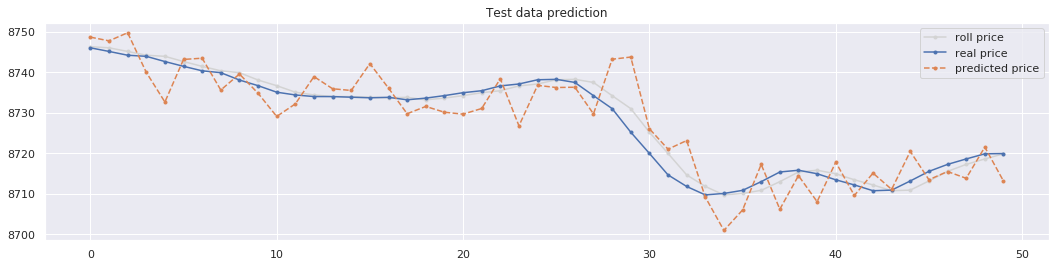

In [31]:
sns.set(style='darkgrid')
plt.plot(np.roll(y_test, 1)[-50:], label='roll price', color='lightgray', marker='o', markersize=3)
plt.plot(y_test[-50:], label='real price', marker='o', markersize=3)
plt.plot(y_hat[-50:], linestyle='dashed', label='predicted price', marker='o', markersize=3)
plt.title('Test data prediction')
plt.legend();

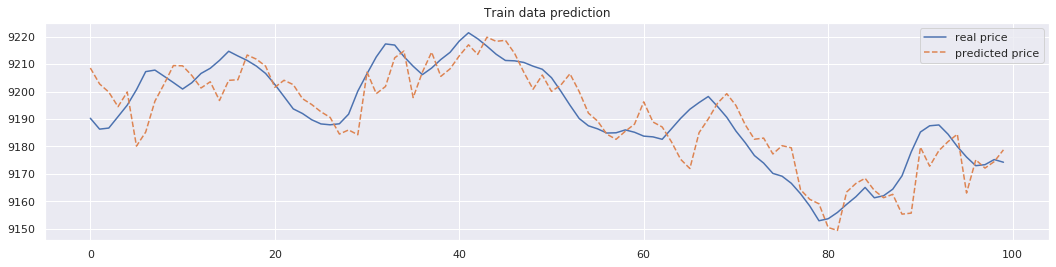

In [32]:
sns.set(style='darkgrid')
plt.plot(y_train[:100], label='real price')
plt.plot(y_hat_train[:100], linestyle='dashed', label='predicted price')
plt.title('Train data prediction')
plt.legend();

### XGBoost

In [307]:
from hyperopt import hp, fmin, tpe, STATUS_OK, STATUS_FAIL, Trials, space_eval, rand

In [281]:
# XGB parameters
xgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'objective':        'reg:squarederror',
    'n_estimators':     10000
}

xgb_fit_params = {
    'eval_metric': 'rmse',
    'early_stopping_rounds': 10,
    'verbose': False
}

xgb_data_params = {
    'n_steps': hp.choice('n_steps', np.arange(1, 24, 1, dtype=int)),
}

xgb_parameters = dict()
xgb_parameters['reg_params']  = xgb_reg_params
xgb_parameters['fit_params']  = xgb_fit_params
xgb_parameters['data_params'] = xgb_data_params

In [282]:
class Hyperopt():
    
    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            print({'status': STATUS_FAIL, 'exception': str(e)})
        else:
            return result, trials

    def xgb_regression(self, parameters):
        model = XGBRegressor(**parameters['reg_params'])
        return self.train(model, parameters)

    def train(self, model, parameters):
        X_train, X_test, y_train, y_test = generate_train_test(**parameters['data_params'])
        
        model.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                **parameters['fit_params'])
        
        y_hat = model.predict(X_test)
        loss = np.sqrt(mean_squared_error(y_test, y_hat))
        
        return {'loss': loss, 'status': STATUS_OK, 'model': model}

In [308]:
optimizer = Hyperopt()

best, trails = optimizer.process(
    fn_name='xgb_regression', 
    space=xgb_parameters, 
    trials=Trials(), 
    algo=rand.suggest,
    max_evals=20)

100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [01:29<00:00,  2.88s/it, best loss: 38.095362672543025]


In [309]:
def get_best_model(trails):
    best_idx = np.argmin([trail['result']['loss'] for trail in trails])
    return list(trails)[best_idx]['result']['model']

def get_best_data_params(parameters, best_params):
    return space_eval(parameters, best_params)['data_params']

In [310]:
data_params = get_best_data_params(xgb_parameters, best)

X_train, X_test, y_train, y_test = generate_train_test(**data_params)

In [311]:
xgboost = get_best_model(trails)

In [312]:
# Predict using the test data
y_hat = xgboost.predict(X_test)
y_hat_train = xgboost.predict(X_train)

In [313]:
# Test baseline
print('Test baseline roll: ${:.2f}'.format(predict_roll(y_test)))
print('Test baseline zero: ${:.2f}'.format(predict_zero(y_test)))
print('Test RMSE: ${:.2f}'.format(rmse(y_hat, y_test)))

Test baseline roll: $34.88
Test baseline zero: $5327.72
Test RMSE: $38.10


In [314]:
# Train baseline
print('Train baseline roll: ${:.2f}'.format(predict_roll(y_train)))
print('Train baseline zero: ${:.2f}'.format(predict_zero(y_train)))
print('Train RMSE: ${:.2f}'.format(rmse(y_hat_train, y_train)))

Train baseline roll: $116.47
Train baseline zero: $8599.96
Train RMSE: $76.55


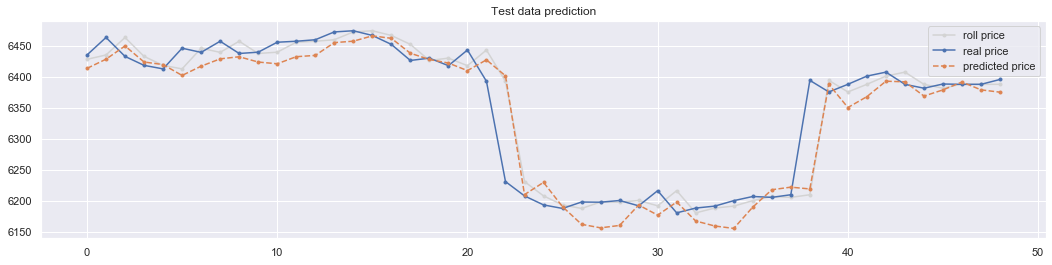

In [315]:
plt.plot(np.roll(y_test, 1)[1:50], label='roll price', color='lightgray', marker='o', markersize=3)
plt.plot(y_test[1:50], label='real price', marker='o', markersize=3)
plt.plot(y_hat[1:50], linestyle='dashed', label='predicted price', marker='o', markersize=3)
plt.title('Test data prediction')
plt.legend();

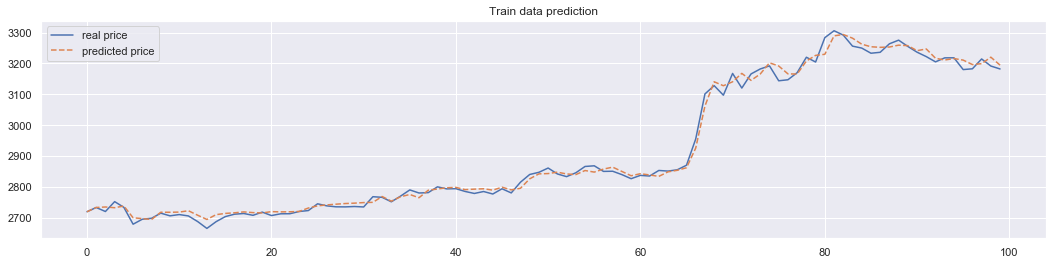

In [316]:
plt.plot(y_train[:100], label='real price')
plt.plot(y_hat_train[:100], linestyle='dashed', label='predicted price')
plt.title('Train data prediction')
plt.legend();